## Plot maps of `TMP2m` trend for both SHiELD/ERA5 and corresponding ACE models

In [49]:
from collections import namedtuple

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs

from utils import get_beaker_dataset_variables
from constants import WANDB_ID_FILE

import yaml
plt.rcParams['figure.dpi'] = 300

In [28]:
with open(WANDB_ID_FILE, "r") as f:
    wandb_ids = yaml.safe_load(f)


In [29]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units"))

EVAL_VARS = [
    EvalVar("TMP2m", "2-meter\nair temperature", "K"),
]
DS_VARS = [x.name for x in EVAL_VARS]

In [30]:
ACE2_SHIELD_RUN = "shield-amip-1deg-ace2-inference-81yr-IC0"
ACE2_ERA5_RUN = "era5-co2-81yr-RS2-IC0-monthly-output"
WANDB_RUNS = {
    "ACE2_SHIELD": wandb_ids[ACE2_SHIELD_RUN],
    "ACE2_ERA5": wandb_ids[ACE2_ERA5_RUN],
}

In [1]:
def compute_slope_intercept(prediction, years):
    return np.polyfit(years, prediction, 1)

def compute_decadal_trend(prediction, years, **ufunc_kwargs):
    result = xr.apply_ufunc(
        compute_slope_intercept,
        prediction,
        years,
        input_core_dims=[
            ("year",),
            ("year",),
        ],
        output_core_dims=[
            ("degree",),
        ],
        vectorize=True,
        **ufunc_kwargs
    )
    decadal_trend = 10 * result.isel(degree=0)
    intercept = result.isel(degree=1)
    return decadal_trend, intercept

In [15]:
# download annual- and global-mean time series from beaker
datasets = []
for name, run in WANDB_RUNS.items():
    tmp = get_beaker_dataset_variables(run, 'monthly_mean_predictions.nc', DS_VARS)
    prediction_dataset = tmp.squeeze().isel(time=slice(None, -3)).groupby('valid_time.year').mean()
    tmp = get_beaker_dataset_variables(run, 'monthly_mean_target.nc', DS_VARS)
    target_dataset = tmp.squeeze().isel(time=slice(None, -3)).groupby('valid_time.year').mean()
    dims = {"dataset": [name]}
    datasets.append(prediction_dataset.expand_dims(dims | {"source": ["prediction"]}))
    datasets.append(target_dataset.expand_dims(dims | {"source": ["target"]}))
annual_ds = xr.merge(datasets)


Output()

Output()

Output()

Output()

In [16]:
annual_ds

<xarray.Dataset> Size: 84MB
Dimensions:    (lat: 180, lon: 360, year: 81, dataset: 2, source: 2)
Coordinates:
  * lat        (lat) float32 720B -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * year       (year) int64 648B 1940 1941 1942 1943 ... 2017 2018 2019 2020
  * dataset    (dataset) object 16B 'ACE2_ERA5' 'ACE2_SHIELD'
  * source     (source) object 16B 'prediction' 'target'
    init_time  datetime64[ns] 8B 1940-01-01
Data variables:
    TMP2m      (dataset, source, year, lat, lon) float32 84MB 227.8 ... 257.9

In [51]:
# for computing global means
weights = np.cos(np.deg2rad(annual_ds.lat))

# compute spatial maps of decadal trends in each dataset
trend_start_year = 1940
trend_end_year = 2020
tmp = annual_ds.sel(year=slice(trend_start_year, trend_end_year))
prediction_trends, _ = compute_decadal_trend(tmp, tmp.year)

# compute global- and annual-mean series
global_annual_ds = annual_ds.weighted(weights).mean(dim=['lat', 'lon'])

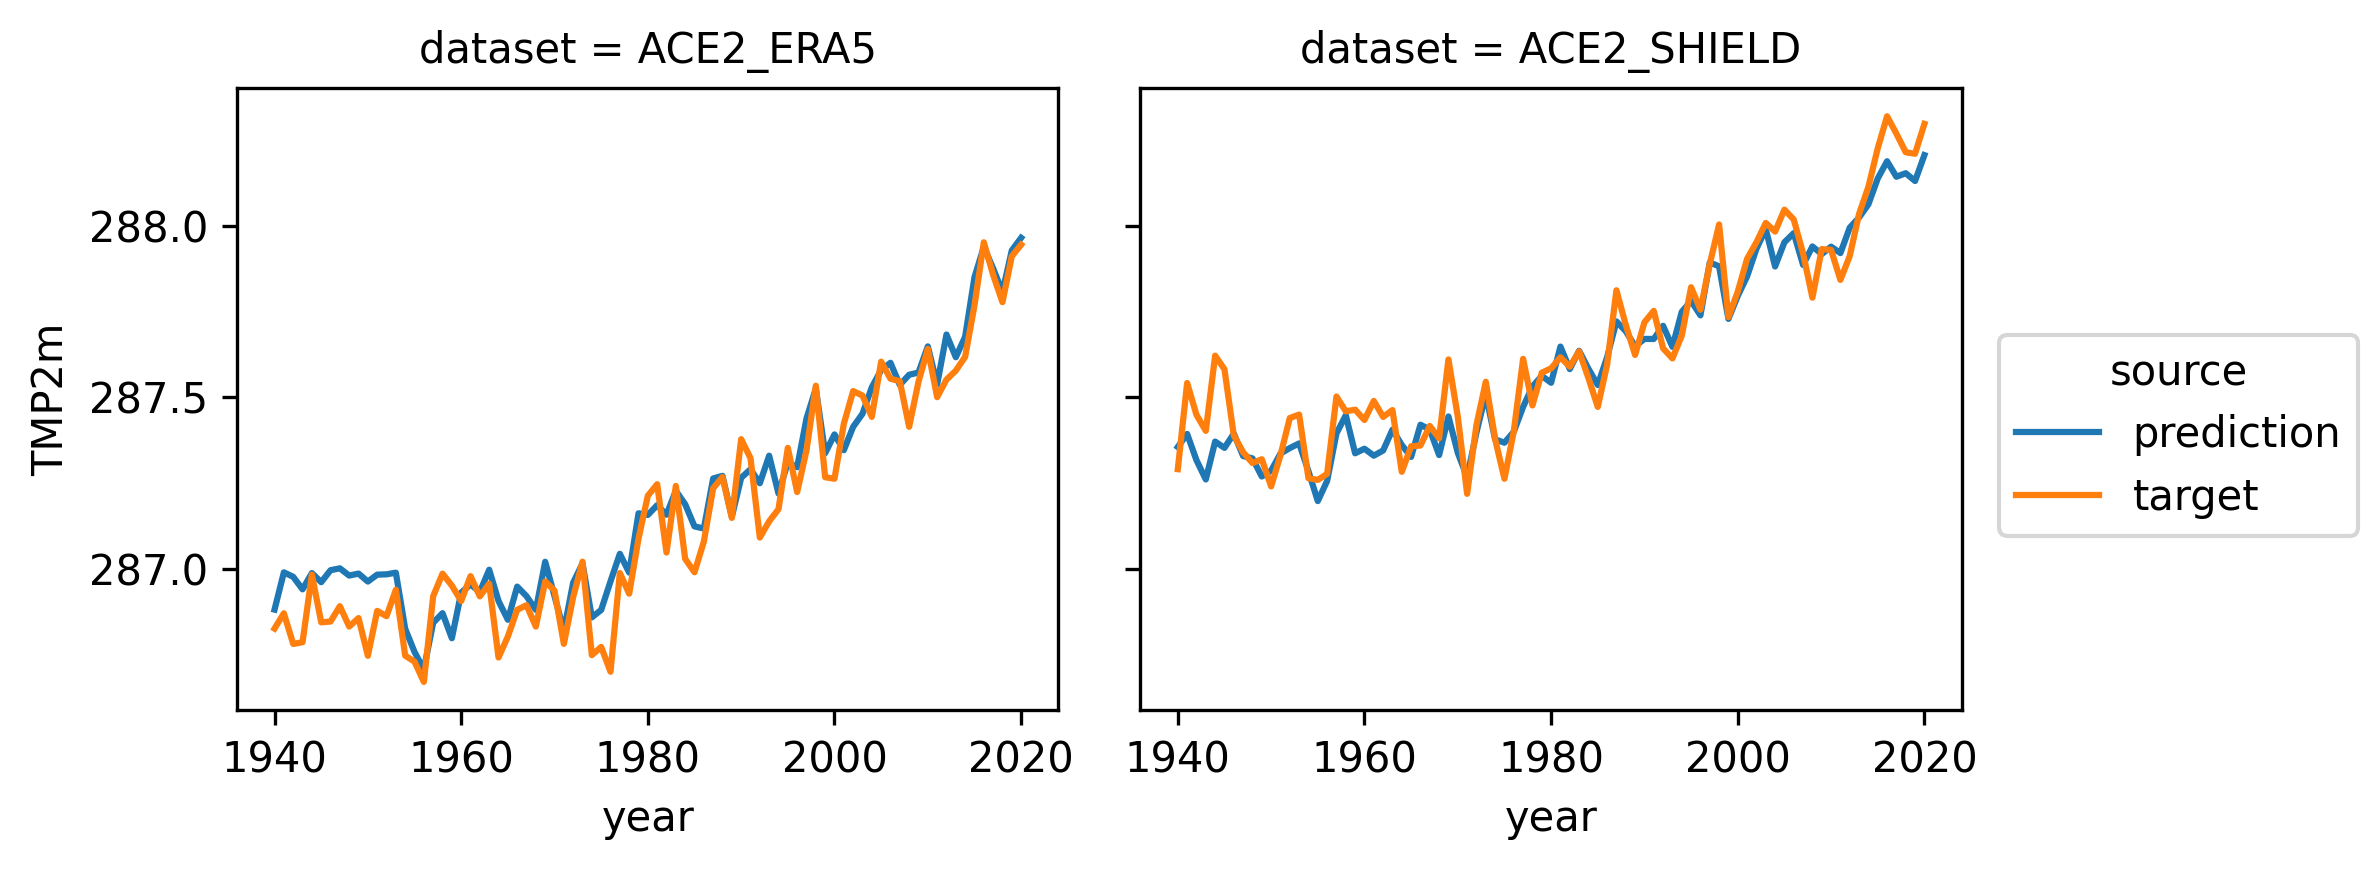

In [52]:
global_annual_ds.TMP2m.plot(hue='source', col='dataset')

ACE2-ERA5 Coordinates:
  * lat        (lat) float32 720B -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    dataset    <U9 36B 'ACE2_ERA5'
    source     <U10 40B 'prediction'
    init_time  datetime64[ns] 8B 1940-01-01
ACE2-SHiELD Coordinates:
  * lat        (lat) float32 720B -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    dataset    <U11 44B 'ACE2_SHIELD'
    source     <U10 40B 'prediction'
    init_time  datetime64[ns] 8B 1940-01-01
ERA5 Coordinates:
  * lat        (lat) float32 720B -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    dataset    <U9 36B 'ACE2_ERA5'
    source     <U6 24B 'target'
    init_time  datetime64[ns] 8B 1940-01-01
SHiELD reference Coordinates:
  * lat        (lat) float32 720B -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
  * lon

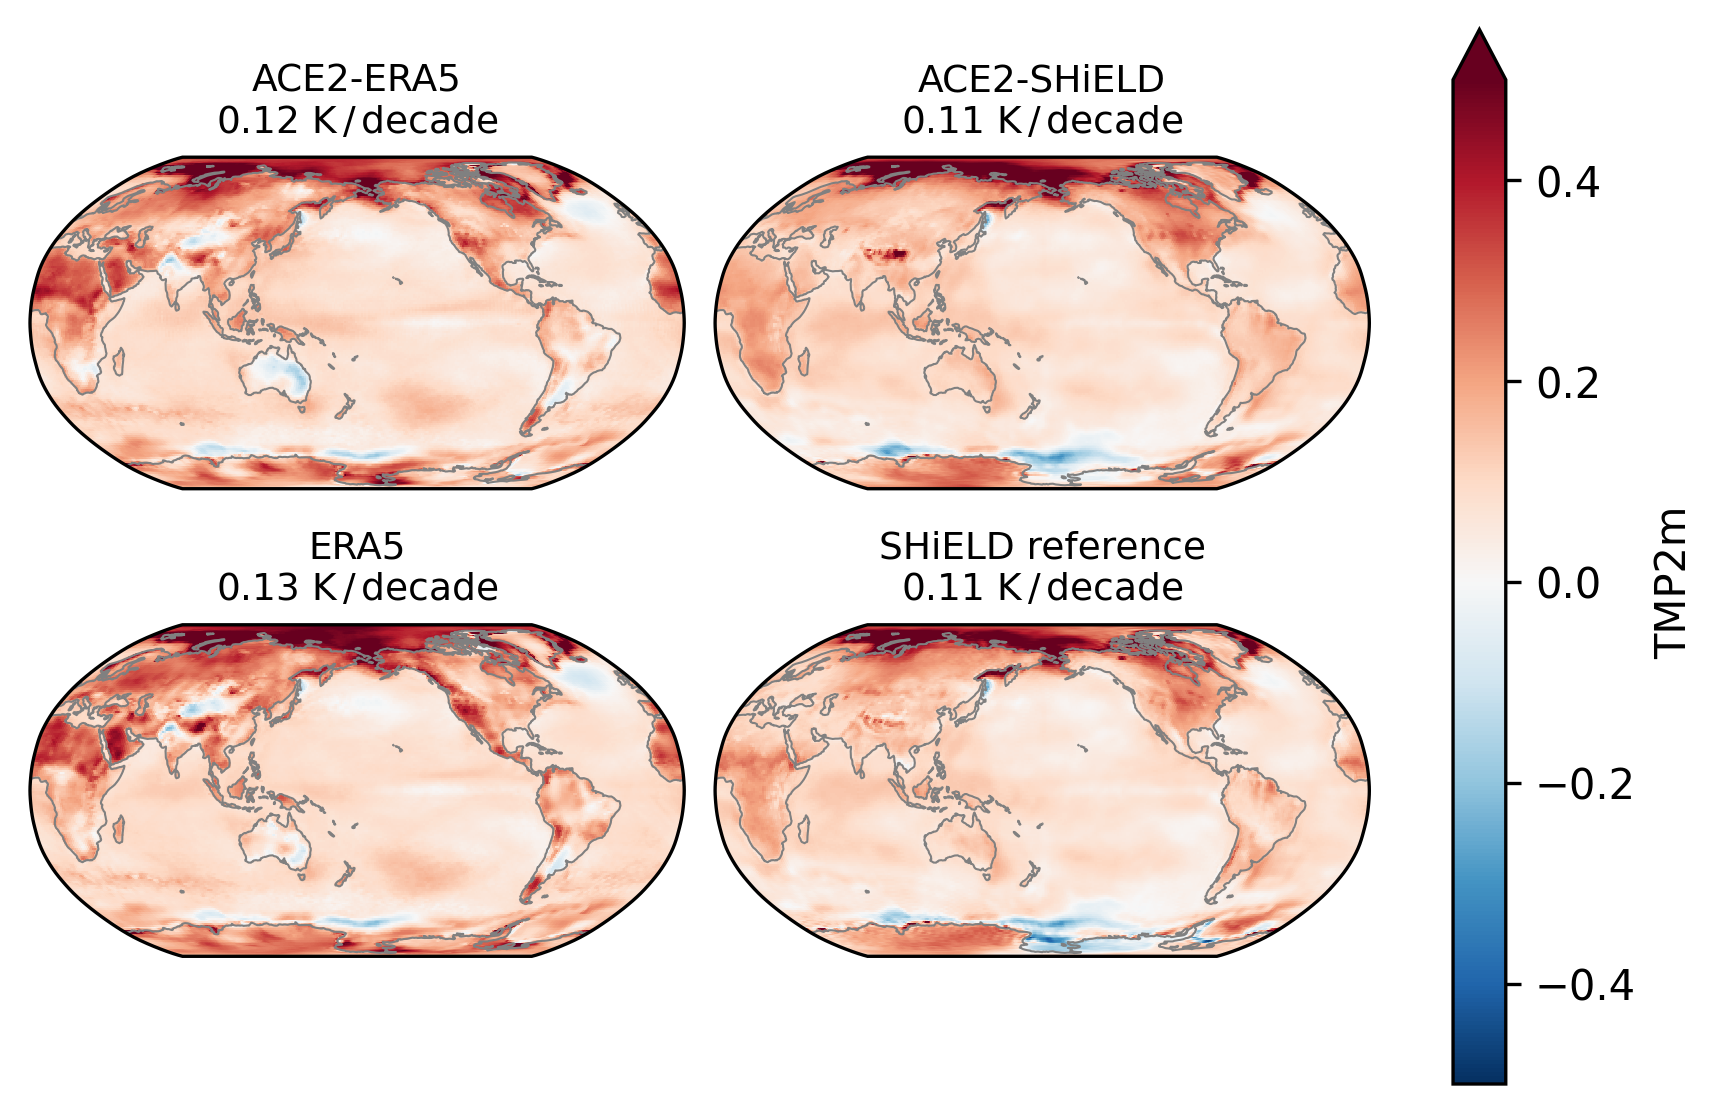

In [66]:
plotme = prediction_trends.TMP2m
fg = plotme.plot(
    col='dataset',
    row='source',
    vmin=-0.5,
    vmax=0.5,
    cmap='RdBu_r',
    transform=ccrs.PlateCarree(),
    subplot_kws=dict(projection=ccrs.Robinson(central_longitude=180)),
)
fg.set_titles(template="")
titles = [['ACE2-ERA5', 'ACE2-SHiELD'], ['ERA5', 'SHiELD reference']]
for i in range(len(fg.axs)):
    for j in range(len(fg.axs[0])):
        global_mean = plotme.isel(source=i, dataset=j).weighted(weights).mean().item()
        print(titles[i][j], plotme.isel(source=i, dataset=j).coords)
        global_mean_str = f"{global_mean:0.2f} K$\,$/$\,$decade"
        fg.axs[i, j].set_title(titles[i][j] + "\n" + global_mean_str, fontsize=9)
        fg.axs[i, j].coastlines(linewidth=0.5, color='grey')

fig = fg.fig
fig.set_size_inches(6, 3.7)